In [1]:
%matplotlib inline

In [2]:
from collections import Counter
from types import MethodType
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from env import GameEnv
from trainer import Trainer

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


In [4]:
def reward_function(value_pair: Tuple) -> float:
    return min(value_pair[0] / 4., 1.)


def final_state_reward(score: float) -> float:
    return -1.


def invalid_move_reward() -> float:
    return 0.


GameEnv.final_state_reward = final_state_reward
GameEnv.reward_function = reward_function
GameEnv.invalid_move_reward = invalid_move_reward

env = GameEnv()


In [5]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.fn1 = nn.Linear(4 * 4, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        self.fn6 = nn.Linear(100, 100)

        self.head = nn.Linear(100, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))
        x = F.relu(self.fn6(x))

        return self.head(x)


In [6]:
# define transformation function
def get_state(self: Trainer):
    with np.errstate(divide='ignore'):
        board = np.where(self.env.board != 0, np.log2(self.env.board), 0)
        return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(self.device)

In [7]:
# define constants
num_episodes = 3000
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 1.
EPS_END = 0.1
EPS_DECAY = 9999
TARGET_UPDATE = 50
MEMORY_SIZE = 10000
optimizer = optim.Adam
optimizer_params = {"lr": 0.0001}
run = "run1"

In [8]:
# define trainer
writer = SummaryWriter(f"runs/{run}")
trainer = Trainer(memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, eps_start=EPS_START, eps_end=EPS_END,
                  eps_decay=EPS_DECAY, target_update=TARGET_UPDATE, env=env, model=DQN, optimizer_klass=optimizer,
                  optimizer_params=optimizer_params,
                  loss_f=F.smooth_l1_loss, is_ipython=is_ipython, writer=writer)

cuda


In [9]:
# assign state method
trainer.get_state = MethodType(get_state, trainer)

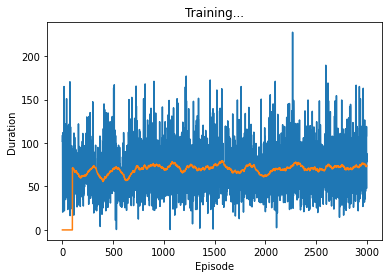

In [10]:
# train
trainer.train(num_episodes)

In [12]:
print(Counter(trainer.get_highest_scores()))

Counter({64: 1305, 128: 1146, 32: 395, 256: 121, 16: 26, 8: 3, 4: 3, 512: 1})


In [11]:
trainer.write_results(run)

<Figure size 432x288 with 0 Axes>